## 12. Exercise: Fashion MNIST Classification

**Your Task**: Adapt the CNN model we've built to classify the Fashion MNIST dataset.

The Fashion MNIST dataset consists of 28×28 grayscale images of 10 fashion categories:
- 0: T-shirt/top
- 1: Trouser
- 2: Pullover
- 3: Dress
- 4: Coat
- 5: Sandal
- 6: Shirt
- 7: Sneaker
- 8: Bag
- 9: Ankle boot

**Steps**:
1. Load the Fashion MNIST dataset instead of regular MNIST
2. Adapt the CNN model if necessary (you might want to use more filters or deeper architecture for this more complex dataset)
3. Train and evaluate the model
4. Visualize the results and compare with the digit classification results

**Hint**: You can load Fashion MNIST using `torchvision.datasets.FashionMNIST` instead of `datasets.MNIST`.

----

### Passo 1: Caricare il dataset Fashion MNIST

Prima di tutto, dobbiamo importare le librerie necessarie e caricare il dataset Fashion MNIST usando torchvision.datasets.FashionMNIST.

📌 Cosa cambia rispetto a MNIST?

Fashion MNIST è simile al classico MNIST (le cifre 0-9), ma contiene immagini di capi di abbigliamento e accessori. Lo carichiamo con torchvision.datasets.FashionMNIST e applichiamo alcune trasformazioni.



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
pl.seed_everything(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Seed set to 42


In [2]:
# Definiamo le trasformazioni per normalizzare il dataset
fashion_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))  # Media e deviazione standard di Fashion MNIST
])

# Define the Fashion MNIST class names for better visualization
fashion_class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                       'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']



In [3]:
# TODO: Create a FashionMNISTDataModule similar to MNISTDataModule

# Creiamo un PyTorch Lightning DataModule per Fashion MNIST
class FashionMNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data", batch_size=64):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.transform = fashion_transform

    def prepare_data(self):
        # Scarica il dataset solo se necessario
        datasets.FashionMNIST(self.data_dir, train=True, download=True)
        datasets.FashionMNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Suddivisione del dataset in train (55k), validation (5k) e test (10k)
        if stage == "fit" or stage is None:
            fashion_full = datasets.FashionMNIST(
                self.data_dir, train=True, transform=self.transform
            )
            self.fashion_train, self.fashion_val = random_split(fashion_full, [55000, 5000])

        if stage == "test" or stage is None:
            self.fashion_test = datasets.FashionMNIST(
                self.data_dir, train=False, transform=self.transform
            )

    def train_dataloader(self):
        return DataLoader(
            self.fashion_train, batch_size=self.batch_size, shuffle=True, num_workers=4
        )

    def val_dataloader(self):
        return DataLoader(self.fashion_val, batch_size=self.batch_size, num_workers=4)

    def test_dataloader(self):
        return DataLoader(self.fashion_test, batch_size=self.batch_size, num_workers=4)        


🎯 Cosa ho fatto?

✅ Creato la classe FashionMNISTDataModule

✅ Gestito download e caricamento dei dati

✅ Suddiviso il dataset in train (55k), validation (5k) e test (10k)

✅ Creati DataLoader per training, validazione e test

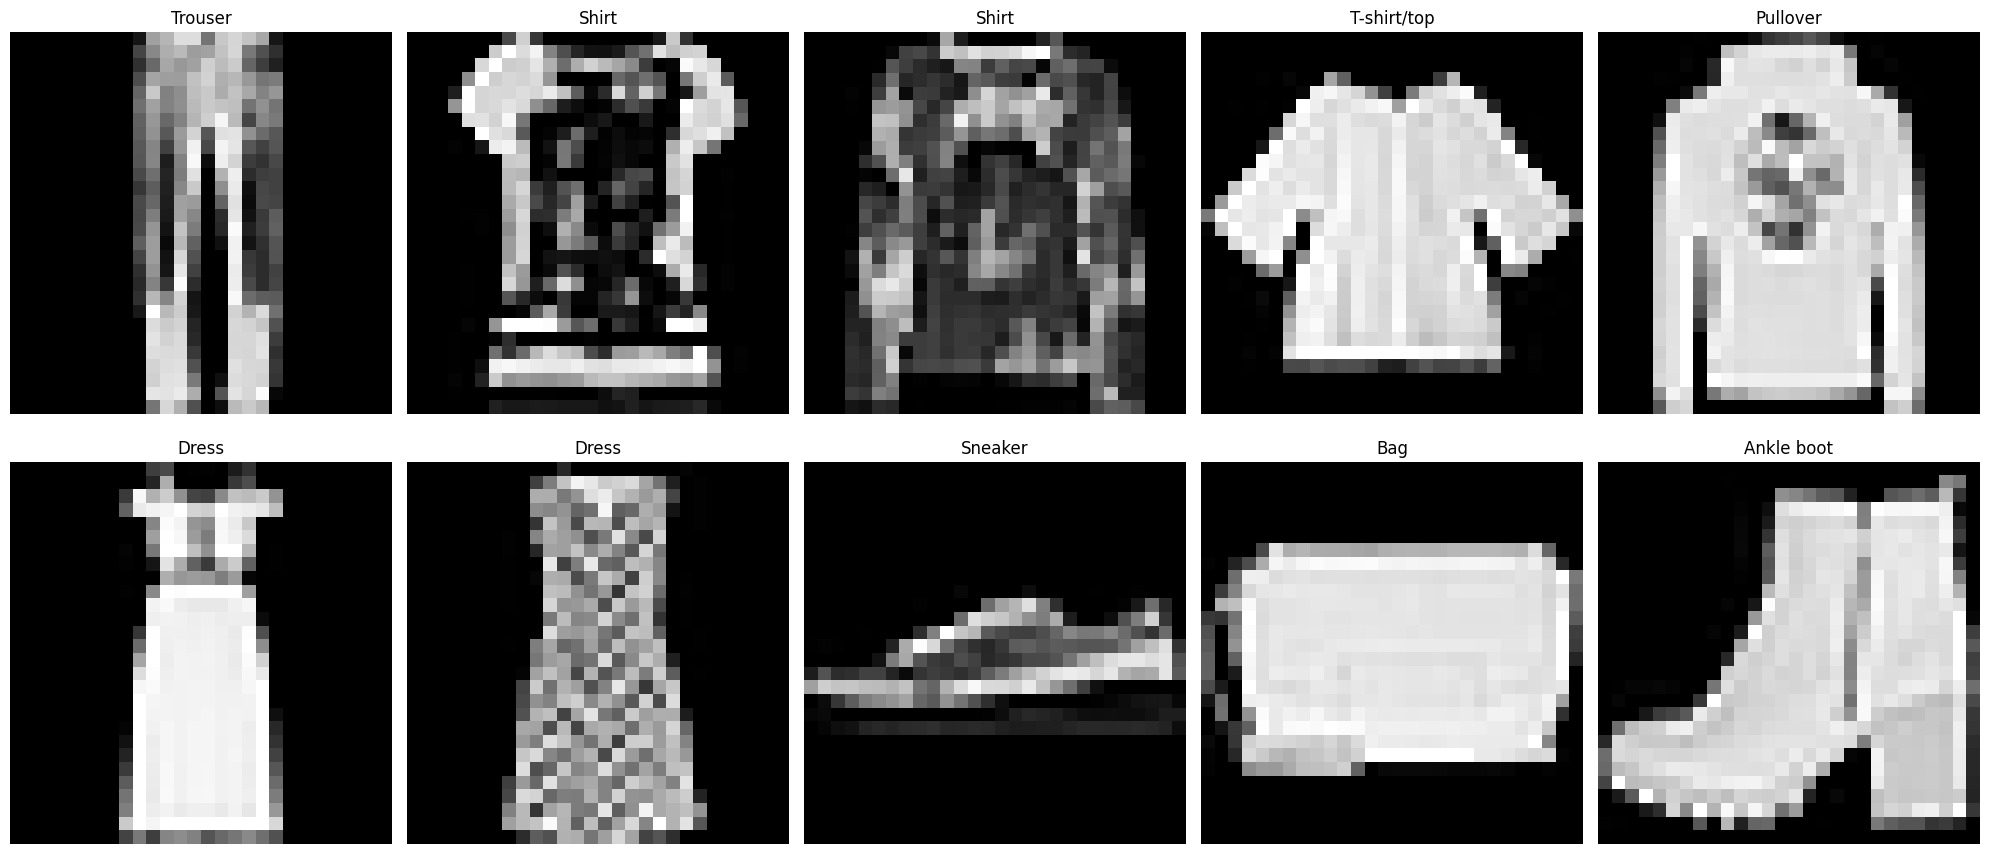

In [4]:
# Carichiamo il dataset Fashion MNIST
fashion_train = datasets.FashionMNIST('./data', train=True, download=True, transform=fashion_transform)

# Mostriamo 10 immagini casuali
fig, axes = plt.subplots(2, 5, figsize=(20, 9))
axes = axes.flatten()

for i, ax in enumerate(axes):
    idx = np.random.randint(len(fashion_train))
    img, label = fashion_train[idx]
    img = img.squeeze().numpy()  # Convertiamo in numpy array

    ax.imshow(img, cmap='gray')
    ax.set_title(fashion_class_names[label])  # Mostriamo il nome della classe
    ax.axis('off')

plt.tight_layout()
plt.show()


🎯 Cosa succede qui?

✅ Selezioniamo 10 immagini casuali dal dataset Fashion MNIST

✅ Convertiamo le immagini in formato visualizzabile

✅ Stampiamo l’immagine con il nome della classe corrispondente

In [6]:
# TODO: Implement FashionMNISTClassifierCNN based on MNISTClassifierCNN


class FashionMNISTClassifierCNN(pl.LightningModule):
    def __init__(self, hidden_size=128, learning_rate=0.001):
        super().__init__()
        self.save_hyperparameters()

        # Layer convoluzionali
        # Primo layer convoluzionale con 32 filtri
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        # Secondo layer convoluzionale con 64 filtri
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # Terzo layer convoluzionale con 128 filtri
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Layer di pooling per ridurre la dimensione spaziale
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calcoliamo la dimensione dell'input per il layer fully connected
        # Dopo 3 strati di pooling, la dimensione diventa 3x3 (28->14->7->3)
        self.fc_input_size = 128 * 3 * 3  # 128 canali, 3x3 immagine

        # Layer completamente connessi
        # Primo layer fully connected
        self.fc1 = nn.Linear(self.fc_input_size, hidden_size)
        # Secondo layer completamente connesso (output per 10 classi)
        self.fc2 = nn.Linear(hidden_size, 10)  # 10 classi per Fashion MNIST

        # Dropout per regolarizzazione, aiuta a evitare overfitting
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # x ha la forma: [batch_size, 1, 28, 28] (immagini in scala di grigi 28x28)

        # Primo blocco convoluzionale
        x = F.relu(self.conv1(x))  # Forma: [batch_size, 32, 28, 28]
        x = self.pool(x)  # Forma: [batch_size, 32, 14, 14]

        # Secondo blocco convoluzionale
        x = F.relu(self.conv2(x))  # Forma: [batch_size, 64, 14, 14]
        x = self.pool(x)  # Forma: [batch_size, 64, 7, 7]

        # Terzo blocco convoluzionale
        x = F.relu(self.conv3(x))  # Forma: [batch_size, 128, 7, 7]
        x = self.pool(x)  # Forma: [batch_size, 128, 3, 3]

        # "Flatten" il tensore per passarlo ai layer fully connected
        x = x.view(-1, self.fc_input_size)  # Forma: [batch_size, 128*3*3]

        # Primo layer completamente connesso
        x = F.relu(self.fc1(x))
        # Applichiamo il dropout per la regolarizzazione
        x = self.dropout(x)
        # Secondo layer completamente connesso (output finale)
        x = self.fc2(x)  # Forma: [batch_size, 10] (10 classi di output)

        return x

    # Step di addestramento
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)

        # Calcoliamo la previsione e l'accuratezza
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        
        # Loggiamo la loss e l'accuratezza durante l'addestramento
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)

        return loss

    # Step di validazione
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)

        # Calcoliamo la previsione e l'accuratezza
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        
        # Loggiamo la loss e l'accuratezza durante la validazione
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

        return loss

    # Step di test
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)

        # Calcoliamo la previsione e l'accuratezza
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        
        # Loggiamo la loss e l'accuratezza durante il test
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)

        return {"test_loss": loss, "test_acc": acc, "preds": preds, "targets": y}

    # Funzione per configurare l'ottimizzatore
    def configure_optimizers(self):
        # Utilizziamo l'ottimizzatore Adam con il learning rate specificato
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer


- Layer Convoluzionali: I layer convoluzionali sono progettati per estrarre caratteristiche dalle immagini. Ho usato più filtri per catturare dettagli più complessi rispetto a MNIST.

- Pooling: Il layer di pooling riduce la dimensione spaziale delle immagini, mantenendo le caratteristiche più importanti.

- Fully Connected Layers: Questi strati prendono l'output dei layer convoluzionali e lo trasformano in una previsione finale.

- Dropout: Aiuta a ridurre l'overfitting durante l'allenamento, disattivando casualmente alcuni neuroni.

In [8]:
# TODO: Train and evaluate your model on Fashion MNIST

# Setup del data module (modulo per gestire i dati)
data_module = FashionMNISTDataModule(batch_size=128)

# Definisce una funzione per addestrare e valutare un modello
def train_and_evaluate(model, model_name, max_epochs=5):
    # Callback per l'early stopping (fermare l'addestramento prima se non ci sono miglioramenti)
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Monitoriamo la perdita sulla validazione
        patience=3,  # Numero di epoche senza miglioramenti prima di fermarsi
        verbose=True,  # Mostra messaggi durante l'early stopping
        mode='min'  # L'early stopping si attiva se la perdita di validazione non diminuisce
    )
    
    # Inizializza il trainer di PyTorch Lightning
    trainer = pl.Trainer(
        max_epochs=max_epochs,  # Numero massimo di epoche per l'addestramento
        callbacks=[early_stopping],  # Aggiunge la callback di early stopping
        accelerator='auto',  # Usa la GPU se disponibile (altrimenti usa la CPU)
        logger=True,  # Usa il logger per monitorare l'addestramento
    )
    
    # Addestra il modello
    print(f"\nTraining {model_name}...")  # Messaggio di inizio allenamento
    trainer.fit(model, data_module)  # Allena il modello sui dati

    # Testa il modello
    print(f"\nTesting {model_name}...")  # Messaggio di inizio testing
    test_results = trainer.test(model, data_module)  # Esegui il test del modello

    return model, test_results  # Restituisce il modello allenato e i risultati del test





In [9]:
# Esegui l'addestramento e la valutazione del modello su Fashion MNIST
fashion_cnn_model = FashionMNISTClassifierCNN(hidden_size=128, learning_rate=0.001)
fashion_cnn_model, fashion_cnn_results = train_and_evaluate(fashion_cnn_model, "Fashion CNN Model", max_epochs=10)


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Training Fashion CNN Model...



  | Name    | Type      | Params | Mode 
----------------------------------------------
0 | conv1   | Conv2d    | 320    | train
1 | conv2   | Conv2d    | 18.5 K | train
2 | conv3   | Conv2d    | 73.9 K | train
3 | pool    | MaxPool2d | 0      | train
4 | fc1     | Linear    | 147 K  | train
5 | fc2     | Linear    | 1.3 K  | train
6 | dropout | Dropout   | 0      | train
----------------------------------------------
241 K     Trainable params
0         Non-trainable params
241 K     Total params
0.966     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

C:\Users\fmonc\AIBOOTCAMP-datascience\.env\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
C:\Users\fmonc\AIBOOTCAMP-datascience\.env\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Metric val_loss improved. New best score: 0.341


Validation: |                                                                                                 …

Metric val_loss improved by 0.062 >= min_delta = 0.0. New best score: 0.280


Validation: |                                                                                                 …

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.279


Validation: |                                                                                                 …

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.241


Validation: |                                                                                                 …

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.235


Validation: |                                                                                                 …

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.214


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.212


Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=10` reached.



Testing Fashion CNN Model...


C:\Users\fmonc\AIBOOTCAMP-datascience\.env\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9175000190734863     │
│         test_loss         │    0.2304137945175171     │
└───────────────────────────┴───────────────────────────┘

Previsioni del modello CNN:


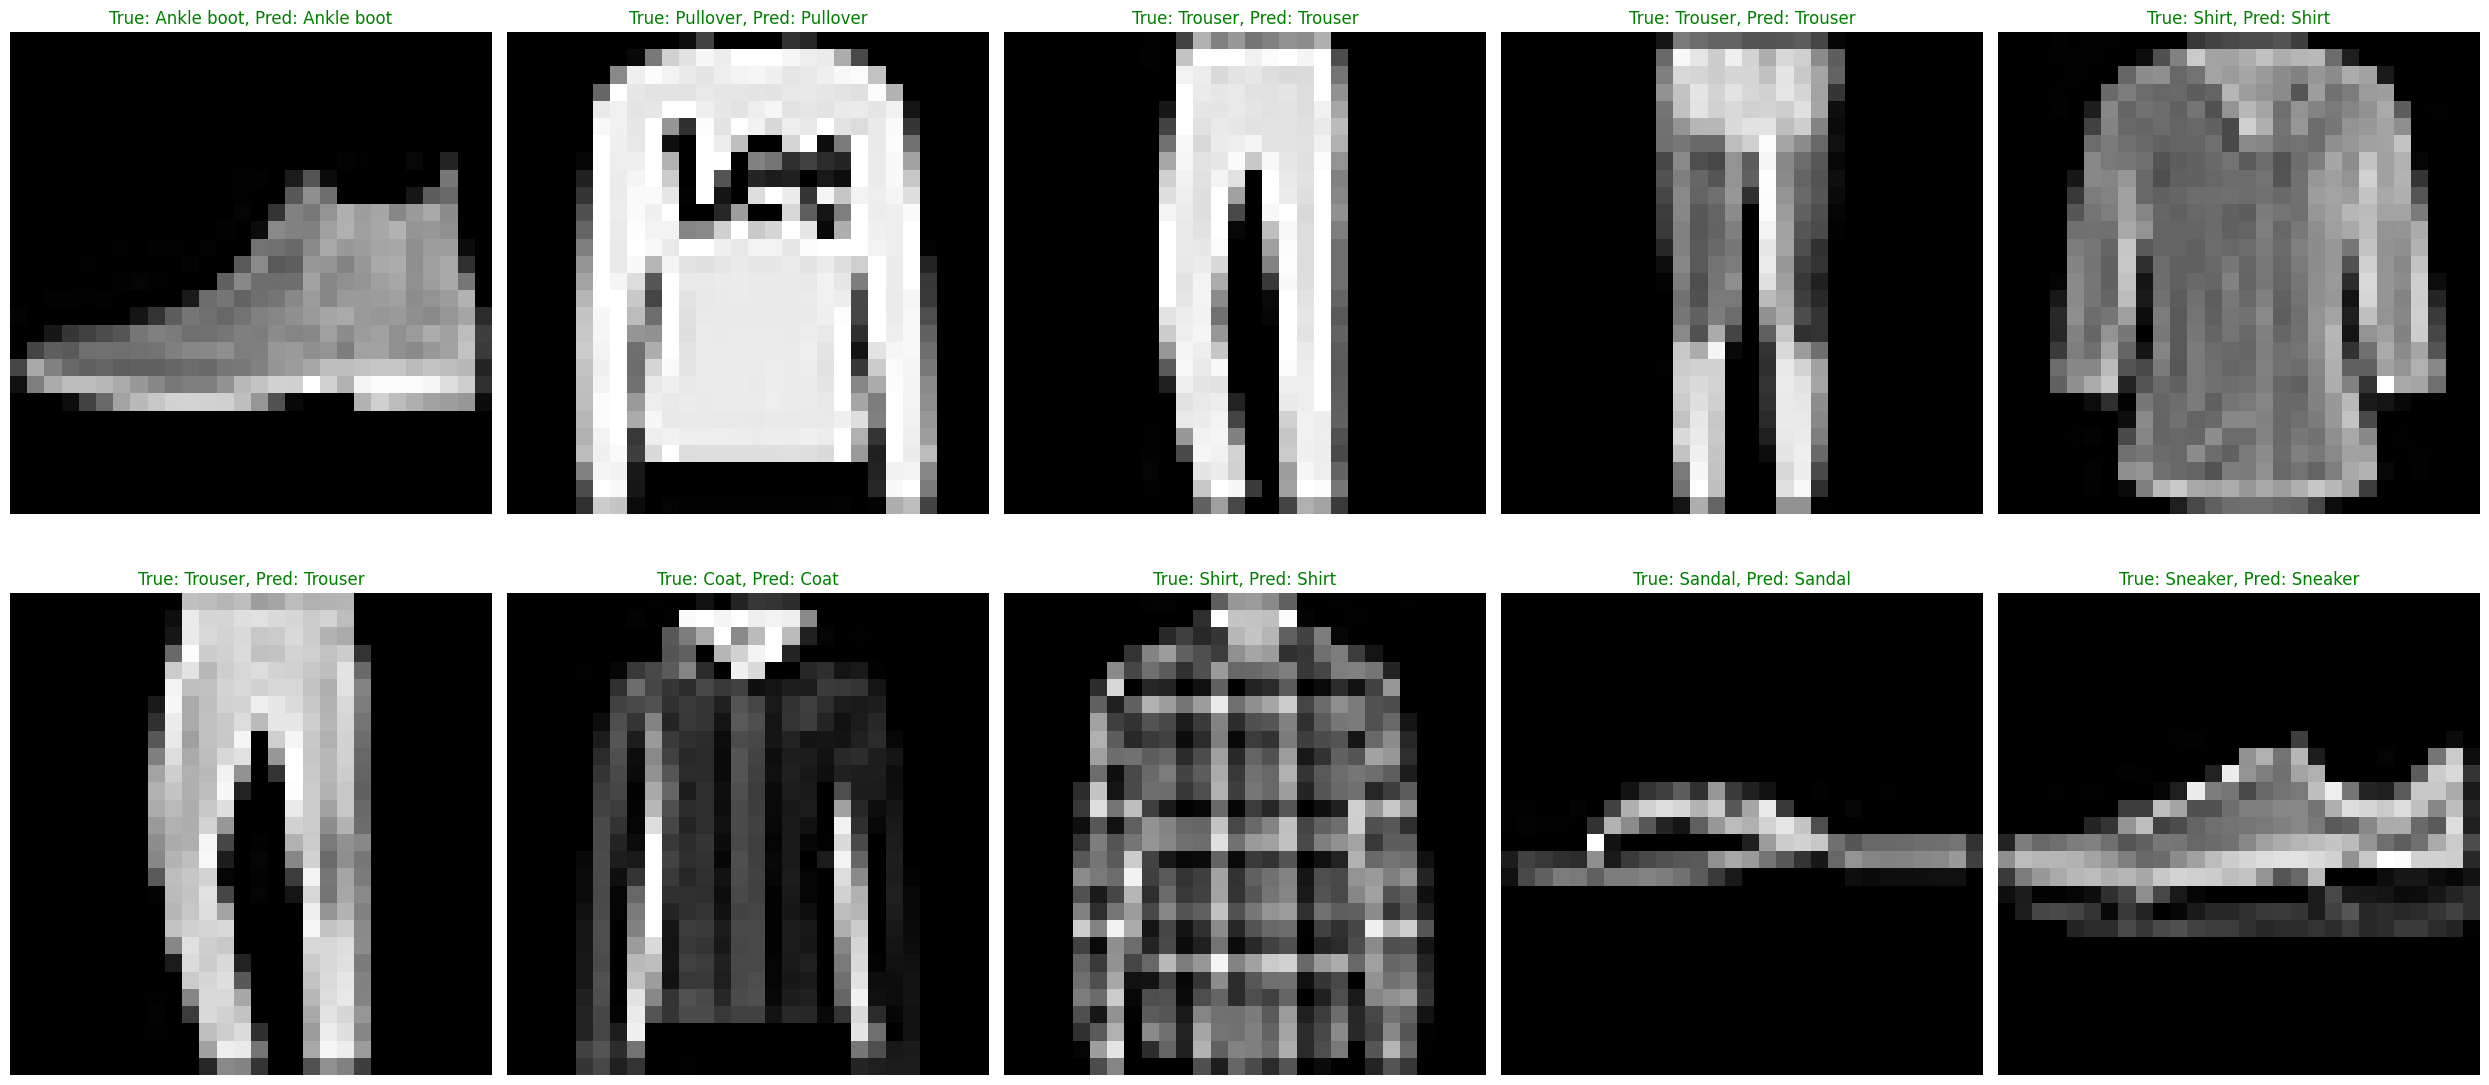

In [11]:
# TODO: Visualize some predictions and analyze the results

def show_predictions(model, data_module, num_samples=10):
    
    # Ottiene un batch di dati di test
    test_loader = data_module.test_dataloader()  # Carica i dati di test
    batch = next(iter(test_loader))  # Estrae un batch di dati dal data loader
    images, labels = batch  # Le immagini e le etichette (true labels)
    
    # Ottiene le previsioni del modello
    model.eval()  # Imposta il modello in modalità di valutazione (disabilita dropout, batch norm, etc.)
    with torch.no_grad():  # Disabilita il calcolo dei gradienti per velocizzare la previsione
        logits = model(images)  # Passa le immagini attraverso il modello per ottenere le previsioni (logits)
        preds = torch.argmax(logits, dim=1)  # Ottiene le classi predette (indice della classe con logit più alto)
    
    # Visualizza le immagini con le previsioni
    fig, axes = plt.subplots(2, 5, figsize=(25, 12))  # Crea una figura con una griglia di 2 righe e 5 colonne
    axes = axes.flatten()  # Appiattisce l'array di assi per un facile accesso
    
    # Cicla sulle immagini e visualizza le previsioni
    for i, ax in enumerate(axes[:num_samples]):  # Mostra fino a 'num_samples' immagini
        img = images[i].squeeze().cpu().numpy()  # Converte l'immagine in un array NumPy per il plotting
        label = labels[i].item()  # Etichetta vera (true label) dell'immagine
        pred = preds[i].item()  # Predizione del modello per l'immagine
        
        # Mostra l'immagine e imposta il colore del titolo in base alla correttezza della previsione
        ax.imshow(img, cmap='gray')  # Visualizza l'immagine in scala di grigi
        title_color = 'green' if pred == label else 'red'  # Colore verde se la previsione è corretta, rosso altrimenti
        ax.set_title(f'True: {fashion_class_names[label]}, Pred: {fashion_class_names[pred]}', color=title_color)  # Titolo con nomi delle classi
        ax.axis('off')  # Rimuove gli assi dalla visualizzazione
    
    plt.tight_layout()  # Ottimizza il layout per evitare sovrapposizioni
    plt.show()  # Mostra il grafico

# Mostra le previsioni del modello CNN
print("Previsioni del modello CNN:")
show_predictions(fashion_cnn_model, data_module)  # Chiama la funzione per visualizzare le previsioni


### Analisi dei Risultati

#### **Performance del Modello**
Tutte le previsioni sono corrette (titoli verdi per ogni immagine) e l'accuratezza è elevata  su questo batch di test. Questo dimostra che la CNN è ben addestrata su Fashion MNIST e riesce a distinguere capi di abbigliamento con caratteristiche visive spesso simili, come "Shirt" e "Pullover".

#### **Complessità del Dataset**
Fashion MNIST è più complesso rispetto a MNIST, perché gli articoli di abbigliamento presentano dettagli e forme più variegate rispetto alle semplici cifre scritte a mano. Categorie come "Shirt" e "Pullover" o "Ankle Boot" e "Sneaker" possono essere difficili da distinguere senza un modello robusto.

#### **Confronto con la Classificazione delle Cifre (MNIST)**

##### **Complessità dei Pattern**
- **MNIST**: Le cifre hanno pattern visivi distinti e semplici, come curve e linee, che rendono la classificazione meno impegnativa.
- **Fashion MNIST**: Le immagini contengono dettagli più intricati, come tessuti e forme specifiche, richiedendo una rete CNN più potente (ad esempio con più strati convoluzionali) per identificare le caratteristiche.

##### **Dimensioni e Architettura del Modello**
Il modello utilizzato su Fashion MNIST ha richiesto **tre strati convoluzionali** per catturare informazioni a diversi livelli di profondità. Un modello per MNIST, invece, potrebbe ottenere buoni risultati con una rete meno complessa. La tabella dei moduli mostra chiaramente che la CNN su Fashion MNIST ha una struttura più robusta rispetto a quella usata per MNIST.



#### **Conclusione**
La visualizzazione dimostra che il modello CNN funziona efficacemente per la classificazione su Fashion MNIST, nonostante sia un dataset più complesso rispetto alle cifre di MNIST. Confrontando i due dataset:
- MNIST presenta pattern semplici e distinti.
- Fashion MNIST richiede una rete più profonda e potente per classificare articoli visivamente simili.


